# ACML Homework: Convolutional Autoencoders


This assigment shows how to use a deep convolutional autoencoder in order to reconstruct the images from CIFAR10 dataset. The goal of image reconstruction is to create a new set of images similar to the original input images.

### Running this notebook:
Make sure you have the `torch, torchvision, numpy, matplotlib, tqdm, opencv` packages installed.

In [1]:
import torch as t
import torchvision  # package contains the image data sets that are ready for use
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (20, 10)
print(t.__version__)

1.11.0.dev20211108


The first step is to pre-process the data. 
The names of the classes over which the dataset is distributed will be defined. There are ten different classes of 32x32 color images. After we have decided on a class name, to make our model train faster, we need to normalize the image.
In this section we:
- downloaded the dataset CIFAR10
- defined the image classes, loaders
- prepared data loaders

Notice that by downloading the data via PyTorch, we already get it normalized in the range `[0,1]`, which is perfect for us. For this reason, the last layer of all the moels contained in this notebook will have a sigmoid activation function, because it naturally outputs values in that range.

In [2]:
# batch_size = the number of samples that will be fed into the model at the same time, after which the loss value will be computed
def get_loaders(train_batch_size=64, test_batch_size=100):
    transform = transforms.Compose(
        [transforms.ToTensor()]
    )
    # Download the training and test datasets
    train_val_set = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform
    )
    # trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
    #                                          shuffle=True, num_workers=2)

    test_set = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform
    )
    # Define the image classes
    classes = (
        "plane",
        "car",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    )
    val_size = 0.1
    num_workers = 2
    print(len(test_set) / (len(train_val_set) + len(test_set)))
    # obtain training indices that will be used for validation
    # validation set is 10% of the training set
    num_train_val = len(train_val_set)
    indices = t.randperm(num_train_val)
    split = int(np.floor(val_size * num_train_val))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders (combine dataset and sampler)
    train_loader = t.utils.data.DataLoader(
        train_val_set,
        batch_size=train_batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
    )
    val_loader = t.utils.data.DataLoader(
        train_val_set,
        batch_size=test_batch_size,
        sampler=valid_sampler,
        num_workers=num_workers,
    )
    test_loader = t.utils.data.DataLoader(
        train_val_set, batch_size=test_batch_size, num_workers=num_workers
    )
    return train_loader, val_loader, test_loader

In [3]:
# functions to show an image


def imshow(img):
    #img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def plot_imgs(imgs):
    imshow(torchvision.utils.make_grid(imgs))


# get some random training images
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# show images
# print labels #print(" ".join("%5s" % classes[labels[j]] for j in range(train_batch_size)))

Convolutional Autoencoder is used in image reconstruction to learn the optimal filters in order to reduce reconstruction errors.
In both arhitectures we start by implementing the encoder. It is effectively a deep convolutional network in which we use strided convolutions to scale down the image layer by layer. After we have a decoder which is the flipped version of the encoder.

### Model 1 structure
The first model to be tested will be using maxUnpooling as a form of upsampling. As the name suggests, this is the partial inverse of the maxPooling. Partial because all the non-maximal value are lost during the poolling operation. MaxPool will set all the non-maximal values to zero.

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class ConvAEUnpool(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.conv1 = nn.Conv2d(3, 8, 3, padding="same")
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.conv2 = nn.Conv2d(8, 12, 3, padding="same")
        self.conv3 = nn.Conv2d(12, 16, 3, padding="same")
        # decoder
        self.unpool = nn.MaxUnpool2d(2)
        self.dec_conv1 = nn.Conv2d(16, 12, 3, padding="same")
        self.dec_conv2 = nn.Conv2d(12, 8, 3, padding="same")
        self.dec_conv3 = nn.Conv2d(8, 3, 3, padding="same")

    def forward(self, x):
        # encoder
        x = F.relu(self.conv1(x))
        x, pool_idx_1 = self.pool(x)
        x = F.relu(self.conv2(x))
        x, pool_idx_2 = self.pool(x)
        x = F.relu(self.conv3(x))
        x, pool_idx_3 = self.pool(x)
        # decoder

        print(f"{t.prod(t.tensor(x.shape[1:]))=}")
        x = self.unpool(x, pool_idx_3)
        x = F.relu(self.dec_conv1(x))
        x = self.unpool(x, pool_idx_2)
        x = F.relu(self.dec_conv2(x))
        x = self.unpool(x, pool_idx_1)
        x = t.sigmoid(self.dec_conv3(x))
        return x

### Model 2 structure
The second model to be tested will be using transpose convolution in the decoder. By puttig `stride=2` we can effectively double the size of the output, i.e., upsample.

In [ ]:
class ConvAETransposeConv(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.conv1 = nn.Conv2d(3, 8, 3, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 12, 3, padding="same")
        self.conv3 = nn.Conv2d(12, 16, 3, padding="same")
        # decoder
        self.dec_conv1 = nn.ConvTranspose2d(16, 12, 2, stride=2)
        self.dec_conv2 = nn.ConvTranspose2d(12, 8, 2, stride=2)
        self.dec_conv3 = nn.ConvTranspose2d(8, 3, 2, stride=2)

    def forward(self, x):
        # encoder
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        # decoder

        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = t.sigmoid(self.dec_conv3(x))
        return x

### Training and Testing
In PyTorch, unlike Keras, one has to create the training loop and the logging from schratch. We also have to explicitly deactivate the autograd engine during testing, zeroing the gradients and tell pytorch to run the parameters optimization.

After a few attempts we have found that a batch size of 32 is a good fit. A smaller batch size increase the likelihood to find a global (not local) minimum, but it also slows down training and it might make it more unstable as well. The test batch size instead should be as large as our GPU can afford.
We have also experimented with step learning rate scheduler, which decreases the learning rate during training. However this did not increase performances. We also tried out BCELoss but this as well did not improve significantly the results.

In [31]:
from tqdm import tqdm


def test(model, device, val_test_set):
    model.eval() # We put the model in eval mode: this disables dropout for example (which we didn't use)
    with t.no_grad(): # Disables the autograd engine
        running_loss = 0.0
        total_length = 0
        for data in tqdm(val_test_set):
            inputs, _ = data

            inputs = inputs.to(device)
            outputs = model(inputs)
            running_loss += t.sum((inputs - outputs)**2).item()
            total_length += len(inputs)
    model.train()
    return running_loss / total_length


def train(
    model_class=ConvAEUnpool,
    train_batch_size=64,
    test_batch_size=200,
    epochs=10,
    lr=0.001,
    lr_step=1,
    gamma=1.0, # 1.0 means disabled
    plot=True,
):
    train_loader, val_loader, test_loader = get_loaders(
        train_batch_size, test_batch_size
    )
    print(f"Len train set: {len(train_loader)}")
    device = t.device("cuda" if t.cuda.is_available() else "cpu") # Select the GPU device, if there is one available.
    # device = t.device('cpu')
    print(device)
    model = model_class().to(device) # The model always stays on the GPU
    # optimizer = the procedure for updating the weights of our neural network
    optimizer = t.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    # criterion = nn.BCELoss()  tested but didn't improve significantly
    scheduler = t.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=gamma)
    history = []
    for epoch in range(epochs):
        model.train()
        print(f"\nEpoch: {epoch + 1}")
        running_loss = 0.0
        total_length = 0
        for param_group in optimizer.param_groups: # Print the updated LR
            print(f"LR: {param_group['lr']}")
        for data in tqdm(train_loader):
            inputs, _ = data
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            inputs = inputs.to(device) # We move the tensors to the GPU for (much) faster computation
            outputs = model(inputs) # Implicitly calls the model's forward function
            loss = criterion(outputs, inputs)
            loss.backward()  # Update the gradients
            optimizer.step() # Adjust model parameters
            total_length += len(inputs)
            running_loss += t.sum((inputs - outputs)**2).item()

        scheduler.step()
        train_loss = running_loss / total_length
        print(f"Train loss: {round(train_loss, 6)}")
        val_loss = test(model, device, val_loader)
        print(f"Val loss: {round(val_loss, 6)}")
        history.append((train_loss, val_loss))
    test_loss = test(model, device, test_loader)
    print(f"Test loss: {round(test_loss, 6)}")
    if plot:
        plot_history(history)
        plot_reconstruction(model, device, test_loader)
    return history, test_loss

In [114]:
def plot_history(history, title='Training history'):
    print(history)
    plt.plot(t.arange(len(history)), [h[0] for h in history], label="Train loss")
    plt.plot(t.arange(len(history)), [h[1] for h in history], label="Val loss")
    plt.legend()
    plt.title(title)
    plt.show()


def plot_reconstruction(model, device, loader):
    with t.no_grad():
        model.eval()
        for batch, _ in loader:
            batch = batch[:8]
            recon_batch = model(batch.to(device))
            plot_imgs(batch)
            plot_imgs(recon_batch.cpu())
            break

### Training Model 1 for 10 epochs


Files already downloaded and verified
Files already downloaded and verified
0.16666666666666666
Len train set: 1407
cuda

Epoch: 1
LR: 0.001


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1248/1407 [00:14<00:01, 93.44it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde45d73af0>
Traceback (most recent call last):
  File "/home/bluesk/miniconda3/envs/acml_assignment_2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/bluesk/miniconda3/envs/acml_assignment_2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/bluesk/miniconda3/envs/acml_assignment_2/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProc

Train loss: 57.575873


  0%|                                                                                                                                                                                                                                    | 0/9 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde45d73af0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fde45d73af0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bluesk/miniconda3/envs/acml_assignment_2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/home/bluesk/miniconda3/envs/acml_assignment_2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/bluesk/miniconda3/envs/acml_assignment_2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/home

Val loss: 36.422236

Epoch: 2
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:17<00:00, 82.44it/s]


Train loss: 32.216116


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.18it/s]


Val loss: 29.07369

Epoch: 3
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:17<00:00, 79.15it/s]


Train loss: 27.43159


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.18it/s]


Val loss: 26.443317

Epoch: 4
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:17<00:00, 80.04it/s]


Train loss: 25.304842


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.26it/s]


Val loss: 24.540438

Epoch: 5
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:18<00:00, 78.12it/s]


Train loss: 23.94613


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.92it/s]


Val loss: 23.530051

Epoch: 6
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:17<00:00, 80.17it/s]


Train loss: 23.106405


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.23it/s]


Val loss: 22.829333

Epoch: 7
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:16<00:00, 83.10it/s]


Train loss: 22.33397


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.74it/s]


Val loss: 22.036855

Epoch: 8
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:17<00:00, 81.87it/s]


Train loss: 21.740034


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.89it/s]


Val loss: 21.486737

Epoch: 9
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:17<00:00, 80.38it/s]


Train loss: 21.269927


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.84it/s]


Val loss: 21.075045

Epoch: 10
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:17<00:00, 81.78it/s]


Train loss: 20.866091


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.06it/s]


Val loss: 20.710479


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:02<00:00, 29.62it/s]


Test loss: 20.641977
[(57.57587310824924, 36.422236328125), (32.216116396755645, 29.07368994140625), (27.431589501274956, 26.443316796875), (25.304842028130427, 24.54043828125), (23.94612956475152, 23.53005126953125), (23.10640539618598, 22.8293333984375), (22.333969713677302, 22.0368552734375), (21.74003419731988, 21.486737109375), (21.269927064005532, 21.075044775390626), (20.866091150241427, 20.7104794921875)]


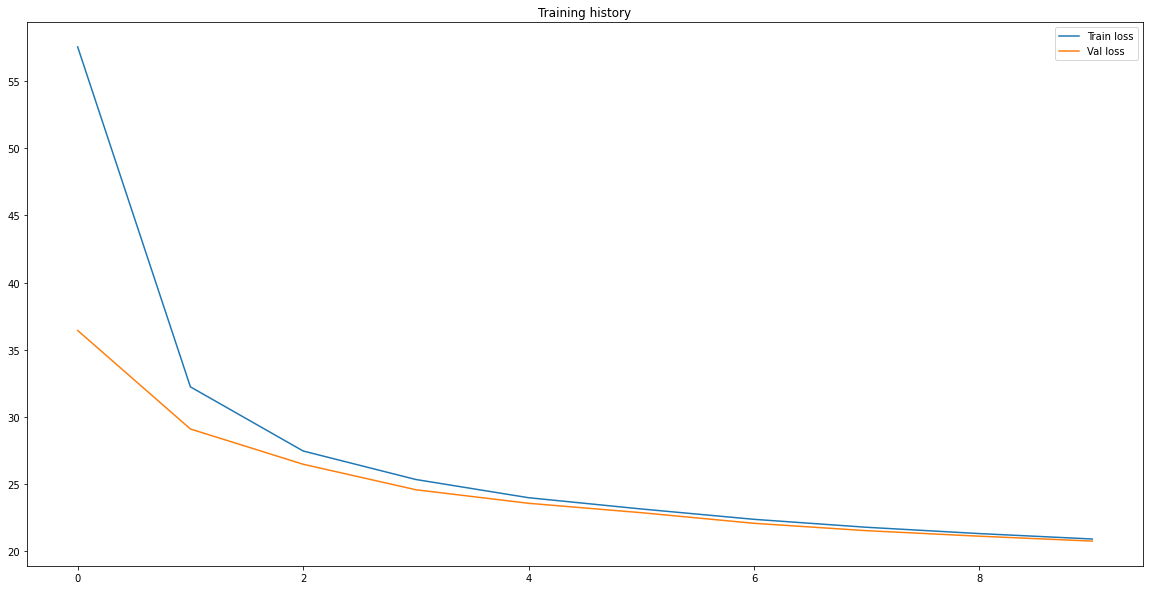

/home/bluesk/miniconda3/envs/acml_assignment_2/lib/python3.9/site-packages/torch/nn/functional.py:735: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


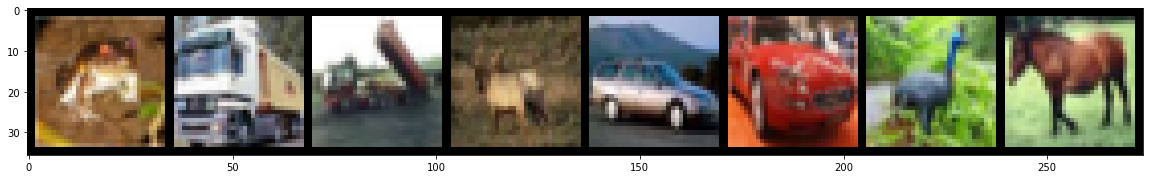

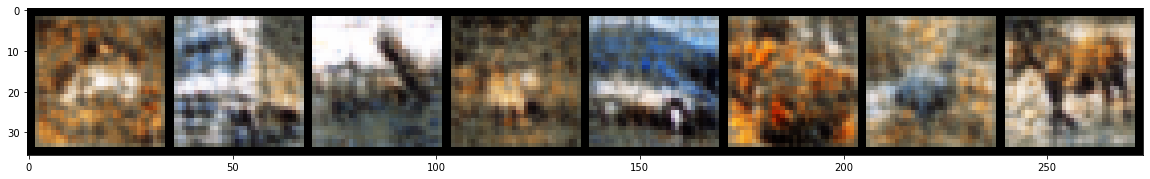

In [33]:
history = train(ConvAEUnpool, 32, 600, 10, 0.001, 1, 1.0)

### Training Model 2 for 10 epochs

Files already downloaded and verified
Files already downloaded and verified
0.16666666666666666
Len train set: 1407
cuda

Epoch: 1
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:18<00:00, 75.89it/s]


Train loss: 75.191831


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.59it/s]


Val loss: 56.289231

Epoch: 2
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:17<00:00, 79.72it/s]


Train loss: 52.272001


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.03it/s]


Val loss: 50.028705

Epoch: 3
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:16<00:00, 83.45it/s]


Train loss: 48.450392


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.88it/s]


Val loss: 47.740264

Epoch: 4
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:18<00:00, 76.16it/s]


Train loss: 46.563895


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.17it/s]


Val loss: 46.373434

Epoch: 5
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:18<00:00, 78.15it/s]


Train loss: 45.377636


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.13it/s]


Val loss: 45.060024

Epoch: 6
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:16<00:00, 84.31it/s]


Train loss: 44.560819


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.04it/s]


Val loss: 44.428702

Epoch: 7
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:18<00:00, 74.87it/s]


Train loss: 43.939684


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.02it/s]


Val loss: 44.281121

Epoch: 8
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:17<00:00, 82.69it/s]


Train loss: 43.493812


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.10it/s]


Val loss: 43.694318

Epoch: 9
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:18<00:00, 74.94it/s]


Train loss: 43.146981


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.01it/s]


Val loss: 43.186372

Epoch: 10
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:16<00:00, 83.13it/s]


Train loss: 42.866547


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.45it/s]


Val loss: 43.100847


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:02<00:00, 29.81it/s]


Test loss: 42.883327
[(75.19183107164172, 56.289230859375), (52.27200107421875, 50.028705078125), (48.450392013210724, 47.740264453125), (46.563895358615454, 46.373434375), (45.377636286756726, 45.0600240234375), (44.56081922132704, 44.42870234375), (43.939683713446726, 44.2811205078125), (43.49381200561523, 43.694318359375), (43.14698088107639, 43.1863716796875), (42.86654688245985, 43.10084658203125)]


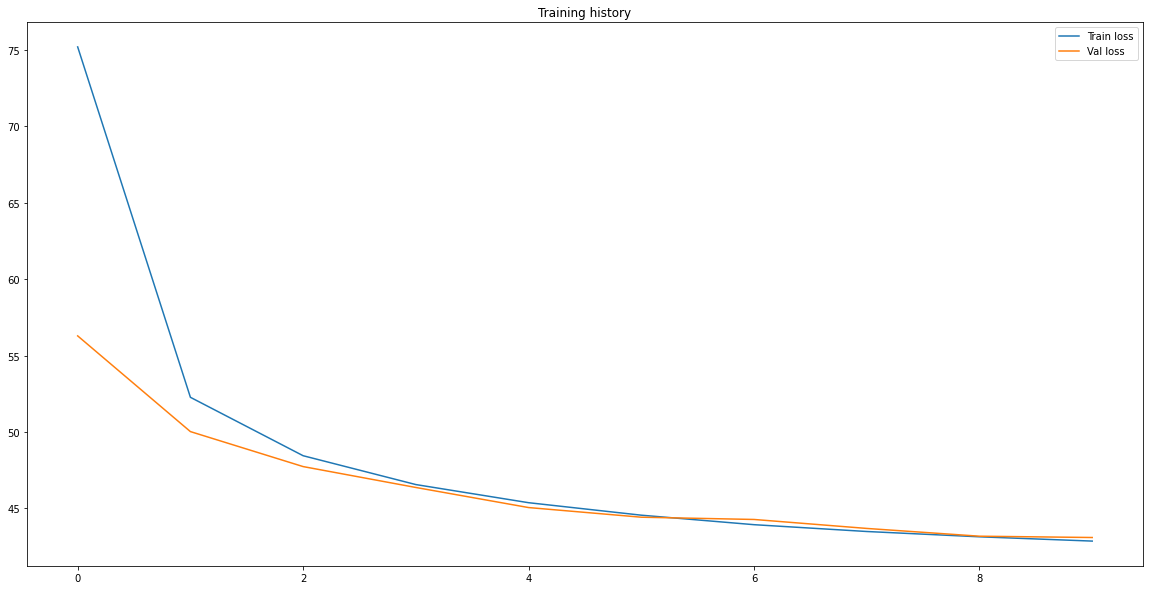

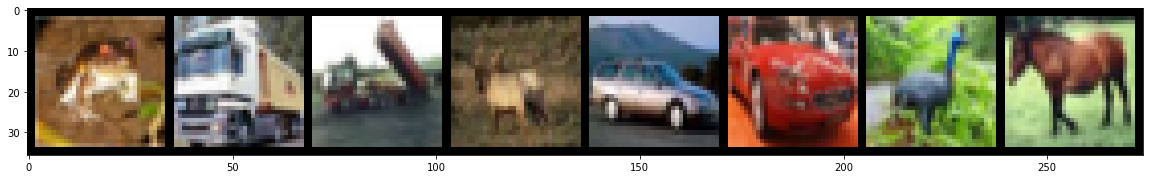

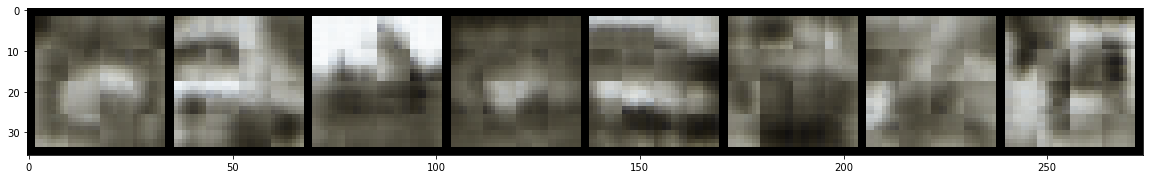

In [34]:
history = train(ConvAETransposeConv, 32, 600, 10, 0.001, 1, 1.0)

### Conclusion
Clearly MaxUnpooling performs much better during a 10-epochs training.

### Training a new Model

If we are allowed to increase the size of the latent space, we can easlily create a model that performs much better. Here train another model with a latent space dimension of 48x4x4=768. We use Transpose convolution as an upsampling technique. The training remains exacly the same, but we use a batch size of 16. 

In [37]:
from torch import nn


class AE2(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),  # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        # print(t.prod(t.tensor(encoded.shape[1:])))
        x = self.decoder(x)
        return x 

Files already downloaded and verified
Files already downloaded and verified
0.16666666666666666
Len train set: 1407
cuda

Epoch: 1
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:16<00:00, 84.81it/s]


Train loss: 43.605217


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.71it/s]


Val loss: 22.705049

Epoch: 2
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:17<00:00, 78.30it/s]


Train loss: 19.094016


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.10it/s]


Val loss: 16.774766

Epoch: 3
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:16<00:00, 86.49it/s]


Train loss: 15.025031


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.54it/s]


Val loss: 13.864298

Epoch: 4
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:16<00:00, 83.04it/s]


Train loss: 13.236252


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.20it/s]


Val loss: 12.851072

Epoch: 5
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:17<00:00, 78.82it/s]


Train loss: 12.243565


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss: 11.81467

Epoch: 6
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:18<00:00, 77.75it/s]


Train loss: 11.245666


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.13it/s]


Val loss: 10.447518

Epoch: 7
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:18<00:00, 75.37it/s]


Train loss: 9.76292


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  6.45it/s]


Val loss: 9.548402

Epoch: 8
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:16<00:00, 85.23it/s]


Train loss: 9.108098


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.00it/s]


Val loss: 8.830018

Epoch: 9
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:17<00:00, 82.17it/s]


Train loss: 8.416674


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss: 8.035122

Epoch: 10
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:16<00:00, 84.70it/s]


Train loss: 7.942134


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  6.62it/s]


Val loss: 7.666579

Epoch: 11
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:18<00:00, 78.12it/s]


Train loss: 7.578322


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.00it/s]


Val loss: 7.537869

Epoch: 12
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:16<00:00, 84.79it/s]


Train loss: 7.083878


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.96it/s]


Val loss: 6.902883

Epoch: 13
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:17<00:00, 82.41it/s]


Train loss: 6.658366


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.53it/s]


Val loss: 6.437295

Epoch: 14
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:17<00:00, 79.40it/s]


Train loss: 6.263091


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.14it/s]


Val loss: 6.469868

Epoch: 15
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:18<00:00, 78.11it/s]


Train loss: 5.966543


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  6.99it/s]


Val loss: 5.777756

Epoch: 16
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:20<00:00, 69.60it/s]


Train loss: 5.702463


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.11it/s]


Val loss: 5.488831

Epoch: 17
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:19<00:00, 72.16it/s]


Train loss: 5.456703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  6.60it/s]


Val loss: 5.375429

Epoch: 18
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:19<00:00, 72.65it/s]


Train loss: 5.269349


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  6.83it/s]


Val loss: 6.887872

Epoch: 19
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:18<00:00, 75.17it/s]


Train loss: 5.111239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.32it/s]


Val loss: 5.204565

Epoch: 20
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:18<00:00, 76.03it/s]


Train loss: 4.973315


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.04it/s]


Val loss: 4.903546


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 43.04it/s]


Test loss: 4.837012
[(43.605217199028864, 22.7050486328125), (19.09401643134223, 16.774765625), (15.02503122829861, 13.864298388671875), (13.236252443101671, 12.85107236328125), (12.243564679463704, 11.81466982421875), (11.245665914408367, 10.447517626953125), (9.762919521755641, 9.54840185546875), (9.10809844004313, 8.830017602539062), (8.416673591105143, 8.035122265625), (7.9421340840657555, 7.666579150390625), (7.57832200334337, 7.53786875), (7.083878040398492, 6.90288330078125), (6.658365818617079, 6.4372947265625), (6.2630907254536945, 6.469867700195312), (5.966542841593425, 5.7777564453125), (5.702463344913059, 5.488831176757812), (5.456703099399143, 5.375428857421875), (5.2693488249037, 6.887871826171875), (5.111238589816623, 5.20456484375), (4.9733153465271, 4.903546276855469)]


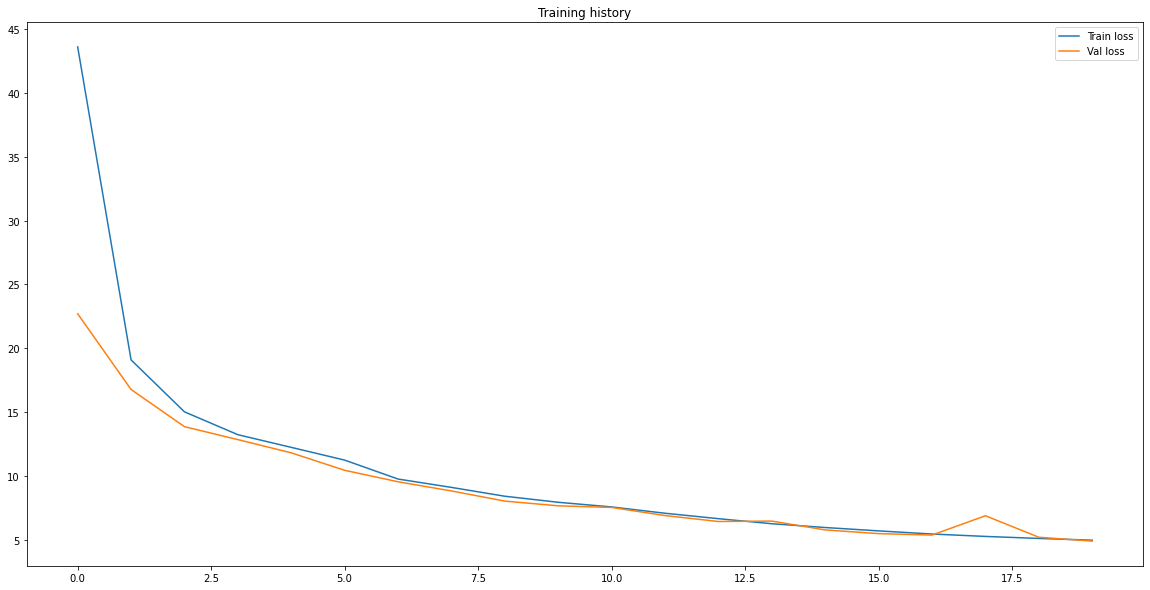

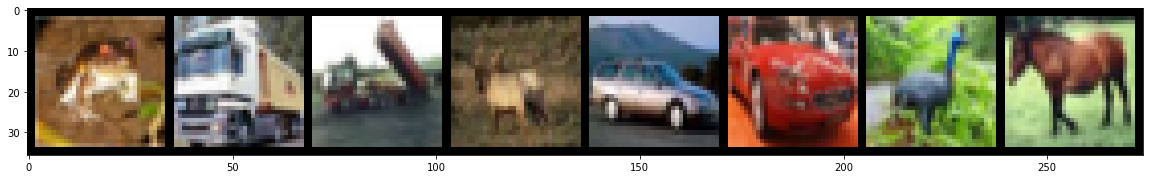

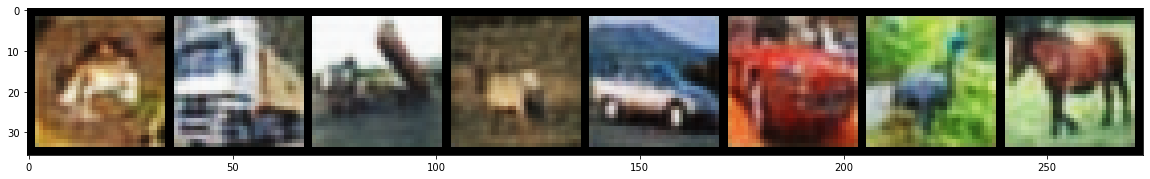

In [38]:
history = train(AE2, 16, 400, 20, 0.001, 1, 1.0)

### Results
This model, trained fro 20 epochs clearly outperforms the two we have previously developed. However we need to take into accound both the longer training time and especially the compression rate.
The initial image size is 3x32x32=3072. Model 1 and Model 2 have both a latent space of size 256, which means a compression rate of 12.
This new model on the other hand has a compression rate of only 4, its latent space of size 768.

## Colorization

First we need to create a function which, as suggested in the assignment, separates the chrominance. For this we can use the YUV format and the opencv library to convert our RGB images. The `get_yuv` function does just that.

In [12]:
import cv2
import numpy as np

# this function was only used to plot the grayscale image
def get_yuv_images(img):
    img = (img.numpy() * 255).astype(np.uint8).transpose(1, 2, 0)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    y, u, v = cv2.split(img_yuv)
    lut_u = np.array([[[i, 255 - i, 0] for i in range(256)]], dtype=np.uint8)
    lut_v = np.array([[[0, 255 - i, i] for i in range(256)]], dtype=np.uint8)
    # Convert back to BGR so we can apply the LUT and stack the images
    y = cv2.cvtColor(y, cv2.COLOR_GRAY2BGR)
    u = cv2.cvtColor(u, cv2.COLOR_GRAY2BGR)
    v = cv2.cvtColor(v, cv2.COLOR_GRAY2BGR)
    u_mapped = cv2.LUT(u, lut_u)
    v_mapped = cv2.LUT(v, lut_v)

    return y, u_mapped, v_mapped


def get_yuv(img):
    img = (img.numpy() * 255).astype(np.uint8).transpose(1, 2, 0)
    img_yuv = t.from_numpy(cv2.cvtColor(img, cv2.COLOR_RGB2YUV)) / 255
    return img_yuv[:, :, :1].transpose(0, 2), img_yuv[:, :, 1:].transpose(0, 2)

We also create some dataloaders for this new dataset

In [13]:
import torch as t


def get_loaders_colorization(train_batch_size=64, test_batch_size=100):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            get_yuv,  # We add the transformation to YUV format to the preprocessing
        ] 
    )
    # Download the training and test datasets
    train_val_set = torchvision.datasets.CIFAR10(
        root="./colorization_data", train=True, download=True, transform=transform
    )

    test_set = torchvision.datasets.CIFAR10(
        root="./colorization_data", train=False, download=True, transform=transform
    )
    val_size = 0.1
    num_workers = 2
    print(len(test_set) / (len(train_val_set) + len(test_set)))
    # obtain training indices that will be used for validation
    # validation set is 10% of the training set
    num_train_val = len(train_val_set)
    indices = t.randperm(num_train_val)
    split = int(np.floor(val_size * num_train_val))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders (combine dataset and sampler)
    train_loader = t.utils.data.DataLoader(
        train_val_set,
        batch_size=train_batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
    )
    val_loader = t.utils.data.DataLoader(
        train_val_set,
        batch_size=test_batch_size,
        sampler=valid_sampler,
        num_workers=num_workers,
    )
    test_loader = t.utils.data.DataLoader(
        train_val_set, batch_size=test_batch_size, num_workers=num_workers
    )
    return train_loader, val_loader, test_loader

### The Colorization Model

Here we have simply adapted the model used previously, by changing the input channels to 1 and the output channels to 2 we can have our model predict the "UV" components of an image given the "Y" component.

In [15]:
from torch import nn

class ConvColorer(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 2, 4, stride=2, padding=1),  # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        # print(t.prod(t.tensor(encoded.shape[1:])))
        decoded = self.decoder(encoded)
        return decoded

In [87]:
def imshow(img):
    plt.imshow(img.T)
    plt.show()


def plot_imgs(imgs_colors, imgs_structures):
    imgs = t.cat((imgs_colors, imgs_structures), dim=1)
    imgs = (imgs * 255).numpy().astype(np.uint8)
    
    rgb_imgs = t.stack([t.from_numpy(cv2.cvtColor(img.T, cv2.COLOR_YUV2RGB)).T for img in imgs])
    #imshow(rgb_imgs[0])
    imshow(torchvision.utils.make_grid(rgb_imgs, nrow=1))

    
def plot_colorer(model, device, loader):
    with t.no_grad():
        model.eval()
        for (structure, colors), _ in loader:
            structure = structure[:8]
            colors = colors[:8]
            output = model(structure.to(device))
            plot_imgs(structure.cpu(), colors.cpu())
            plot_imgs(structure.cpu(), output.cpu())
            break

### Training and Testing
Training and testing remains almost unchanged: we only need to take into account that now we don't have to predict the image itself but only two of its components.

In [119]:
from tqdm import tqdm


def test_colorer(model, device, criterion, val_test_set):
    model.eval()
    with t.no_grad():
        running_loss = 0.0
        total_length = 0
        for data in tqdm(val_test_set):
            (structures, colors), _ = data

            inputs = structures.to(device)
            outputs = model(inputs)
            colors = colors.to(device)
            running_loss += t.sum((colors - outputs)**2).item()
            total_length += len(inputs)
    model.train()
    return running_loss / total_length


def train_colorer(
    model_class=ConvColorer,
    train_batch_size=64,
    test_batch_size=200,
    epochs=10,
    lr=0.001,
    lr_step=1,
    gamma=1.0,
    plot=True,
):
    train_loader, val_loader, test_loader = get_loaders_colorization(
        train_batch_size, test_batch_size
    )
    device = t.device("cuda" if t.cuda.is_available() else "cpu")
    print(device)
    model = model_class().to(device)
    # optimizer = the procedure for updating the weights of our neural network
    optimizer = t.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    # criterion = nn.BCELoss()
    scheduler = t.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=gamma)
    history = []
    for epoch in range(epochs):

        model.train()
        print(f"\nEpoch: {epoch + 1}")
        running_loss = 0.0
        total_length = 0
        for param_group in optimizer.param_groups:
            print(f"LR: {param_group['lr']}")
        for data in tqdm(train_loader):
            (structures, colors), _ = data
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            inputs = structures.to(device)
            colors = colors.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, colors)
            loss.backward()
            optimizer.step()
            total_length += len(inputs)
            running_loss += t.sum((colors - outputs)**2).item()
        scheduler.step()
        train_loss = running_loss / len(train_loader)
        print(f"Train loss: {round(train_loss, 6)}")
        val_loss = test_colorer(model, device, criterion, val_loader)
        print(f"Val loss: {round(val_loss, 6)}")
        history.append((train_loss, val_loss))
    test_loss = test_colorer(model, device, criterion, test_loader)
    print(f"Test loss: {round(test_loss, 6)}")
    
    train_history = np.array([h[0] for h in history])
    max_th = np.max(train_history)
    min_th = np.min(train_history)
    train_history = (train_history - min_th)/(max_th-min_th)
    
    val_history = np.array([h[1] for h in history])
    max_vh = np.max(val_history)
    min_vh = np.min(val_history)
    val_history = (val_history - min_vh)/(max_vh-min_vh)
    history = list(zip(train_history, val_history))
    if plot:
        plot_history(history, 'Normalized training history')
        plot_colorer(model, device, test_loader)
    return history, test_loss

Files already downloaded and verified
Files already downloaded and verified
0.16666666666666666
cuda

Epoch: 1
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:20<00:00, 67.20it/s]


Train loss: 231.562295


 12%|██████████████████████████▎                                                                                                                                                                                                | 3/25 [00:00<00:02,  7.45it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fedbe7b6af0>
Traceback (most recent call last):
  File "/home/bluesk/miniconda3/envs/acml_assignment_2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/bluesk/miniconda3/envs/acml_assignment_2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/bluesk/miniconda3/envs/acml_assignment_2/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProc

Val loss: 7.125712

Epoch: 2
LR: 0.0009000000000000001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:19<00:00, 71.36it/s]


Train loss: 220.524608


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 11.72it/s]


Val loss: 6.914587

Epoch: 3
LR: 0.0008100000000000001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:19<00:00, 73.65it/s]


Train loss: 215.965515


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 12.32it/s]


Val loss: 6.755974

Epoch: 4
LR: 0.000729


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:19<00:00, 71.50it/s]


Train loss: 212.240442


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 11.80it/s]


Val loss: 6.726722

Epoch: 5
LR: 0.0006561000000000001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:19<00:00, 72.86it/s]


Train loss: 209.767157


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 12.18it/s]


Val loss: 6.673169

Epoch: 6
LR: 0.00059049


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:19<00:00, 70.45it/s]


Train loss: 207.479245


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 12.75it/s]


Val loss: 6.639629

Epoch: 7
LR: 0.000531441


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:19<00:00, 70.90it/s]


Train loss: 205.998262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 12.31it/s]


Val loss: 6.581034

Epoch: 8
LR: 0.0004782969


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:20<00:00, 69.10it/s]


Train loss: 204.433297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 12.38it/s]


Val loss: 6.579796

Epoch: 9
LR: 0.00043046721


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:19<00:00, 71.90it/s]


Train loss: 203.283445


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 12.54it/s]


Val loss: 6.55393

Epoch: 10
LR: 0.000387420489


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:19<00:00, 72.15it/s]


Train loss: 202.181722


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.82it/s]


Val loss: 6.599271

Epoch: 11
LR: 0.0003486784401


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:19<00:00, 71.55it/s]


Train loss: 200.952194


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 12.92it/s]


Val loss: 6.519372

Epoch: 12
LR: 0.00031381059609000004


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:20<00:00, 69.70it/s]


Train loss: 200.245315


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 13.75it/s]


Val loss: 6.525096

Epoch: 13
LR: 0.00028242953648100003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:20<00:00, 68.87it/s]


Train loss: 199.133987


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 12.58it/s]


Val loss: 6.508308


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 52.81it/s]


Test loss: 6.215348
[(1.0, 1.0), (0.6596280357056704, 0.6580433023971746), (0.5190381051285178, 0.40114123004545704), (0.40416708681321734, 0.3537616611650335), (0.3278977743541583, 0.2670224597761524), (0.2573448559497218, 0.21269765723666212), (0.21167540300271637, 0.11779209133003748), (0.1634161599226276, 0.1157873346099421), (0.1279578867860904, 0.07389211863851099), (0.09398377787028858, 0.14733115229341678), (0.05606852210656108, 0.01791884282300772), (0.0342703149930844, 0.027191188655682003), (0.0, 0.0)]


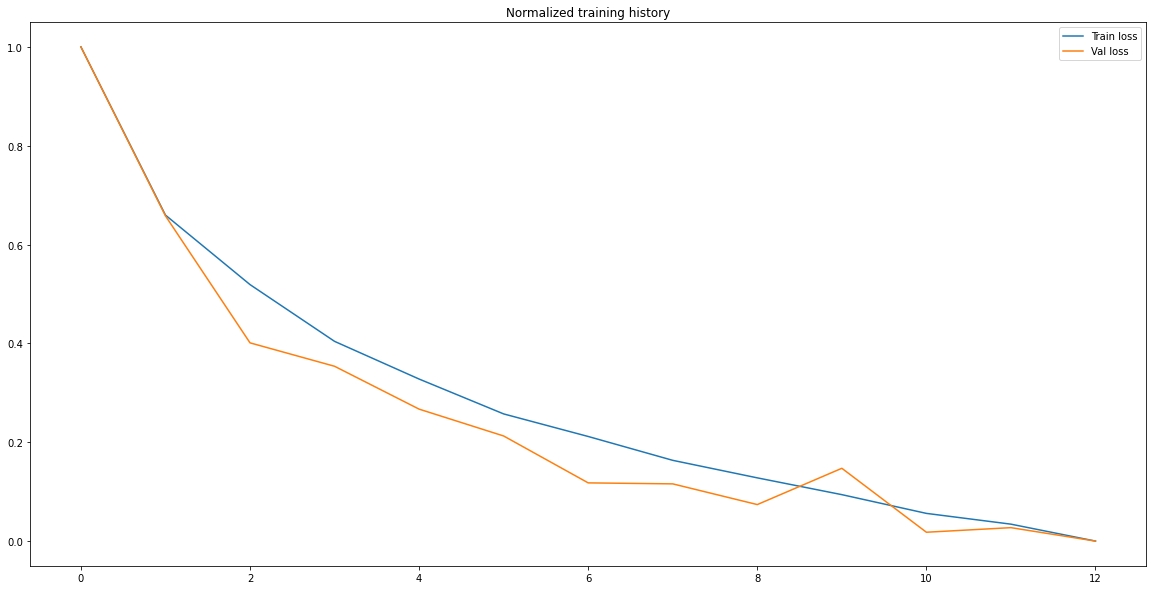

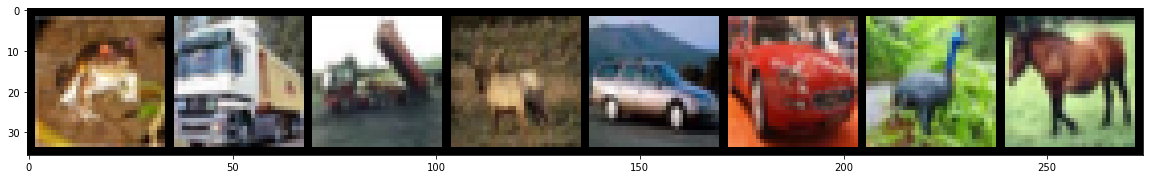

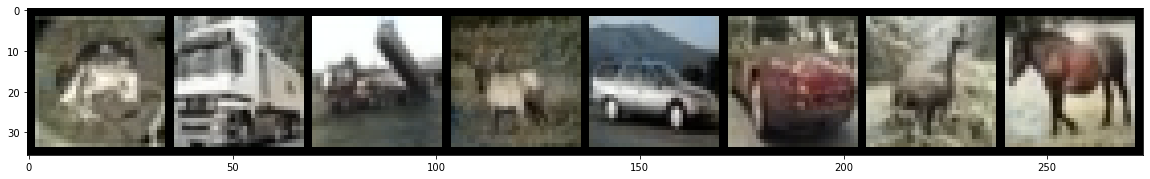

In [125]:
history, test_loss= train_colorer(
    model_class=ConvColorer,
    train_batch_size=32,
    test_batch_size=200,
    epochs=13,
    lr=0.001,
    lr_step=1,
    gamma=0.90,
    plot=True,
)

## Results
The results aren't perfect but it's clear that our model is indeed learning to color images. There are a number of things that could be inproved, among them:
- **tune further the training hyperparameters**
- we could use a deeper neural netowrk
- training for more epochs 
- experiment more with hyperparameters
- Use batch normalization
- Add residual connections in case of a much deeper neural network
- Try more image encoding schemes

## Conclusions
A variety of models were tested: Autoencoders are a powerful tool for any task that involves unsupervised training, among which (partial) image reconstruction (like coloring) or denoising.